In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, average_precision_score, make_scorer, recall_score,accuracy_score)
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LassoCV, Lasso
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DA_G9/cleaned_and_encoded_dataset2.csv")

In [ ]:
# recall for bad customers (label 1) ─ this is already the default
recall_bad = make_scorer(recall_score, pos_label=1)

# specificity (true‑negative rate for good customers)
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)
specificity_good = make_scorer(specificity, greater_is_better=True)

In [ ]:
# train-test-split
X = df.drop(columns=['bad_flag', 'customer_id']).copy()
y = df['bad_flag'].copy()
ids = df['customer_id'].copy()

X_train, X_test, y_train, y_test, id_train, id_test= train_test_split(
    X, y, ids, test_size=0.2, random_state=42, stratify=y
)
sampler = RandomUnderSampler(random_state=42)

In [ ]:
#XGboost
from xgboost import XGBClassifier
start_time = time.time()
xgb = XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric='auc', objective='binary:logistic')

In [ ]:
xgb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:02:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# u want to know how often a feature is used to split the data across all trees.
imp_xgb = xgb.feature_importances_
feat_rank_xgb = (pd.Series(imp_xgb, index=X.columns)
             .sort_values(ascending=False)
             .to_frame('importance'))
print(feat_rank_xgb.head(25))

                               importance
cl_delinquency_ratio             0.142675
debt_to_income_ratio             0.133263
job_self                         0.108463
no_of_derog                      0.093506
job_profExe                      0.049516
no_of_delinq                     0.046229
job_office                       0.040207
job_other_nonProvided            0.037745
age_of_oldest_cl                 0.037711
job_sales                        0.035986
approx_income                    0.034534
no_of_recent_credit_inquiries    0.032712
current_property_value           0.029278
no_of_cl                         0.027414
loan_amt_requested               0.027290
years_on_job                     0.026175
loan_reason_homeImp              0.025219
combined_ltv_ratio               0.024852
mort_due                         0.024570
job_mgr                          0.022655
income_group_high                0.000000
income_group_lowMed              0.000000
loan_reason_debtCon_np           0

Stratified Sampling

In [ ]:
# Evaluation metrics
print(xgb.get_xgb_params())

default_params = xgb.get_params()

# Print key ones
for param in ['colsample_bytree', 'n_estimators', 'learning_rate',
              'max_depth', 'min_child_weight', 'gamma',
              'subsample', 'reg_alpha', 'reg_lambda']:
    print(f"{param}: {default_params[param]}")

y_pred = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("Accuracy test:", accuracy_score(y_test, y_pred))
print("Accuracy train:", accuracy_score(y_train, y_pred_train)) #Large gap = not overfitting

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC :", roc_auc_score(y_test, y_prob).round(3))
print("PR-AUC :", average_precision_score(y_test, y_prob).round(3))

cm_xgb = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm_xgb.ravel()
print(f"\nRecall (bad) : {tp / (tp + fn):.3f}")
print(f"Specificity (good) : {tn / (tn + fp):.3f}")
print(f"tn, fp, fn, tp : {tn:.0f}, {fp:.0f}, {fn:.0f}, {tp:.0f}")

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': 'auc', 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 1, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}
colsample_bytree: None
n_estimators: None
learning_rate: None
max_depth: None
min_child_weight: None
gamma: None
subsample: None
reg_alpha: None
reg_lambda: None
Accuracy test: 0.9431034482758621
Accuracy train: 0.9997842968075927
        

Stratified - Default Randomised search

In [ ]:
param_dist = {
    'clf__max_depth': [3, 4, 5, 6, 7, 8, 9, 10], #Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
    'clf__min_child_weight': [1, 2, 3, 4], # The larger min_child_weight is, the more conservative the algorithm will be.
    'clf__gamma': [0.0, 0.1, 0.2, 0.3, 0.4], #Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
    'clf__subsample': [0.5, 0.6, 0.7],  #Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting.
    'clf__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9], #is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed
    'clf__lambda': [1, 1.5, 2, 2.5, 3], #L2 regularization term on weights. Increasing this value will make model more conservative.
    'clf__alpha': [1], #L1 regularization term on weights. Increasing this value will make model more conservative.
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__n_estimators': [100, 200, 300, 400, 500]
   # 'scale_pos_weight': [1, 2, 3, 4]  # Depending on the class imbalance
}

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Set up RandomizedSearchCV
random_xgb = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=50
        , scoring= 'accuracy'
        # , refit = 'recall_bad'
        , n_jobs=-1, cv=cv, verbose=2, random_state=42)

In [ ]:
random_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:03:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "clf__alpha", "clf__colsample_bytree", "clf__gamma", "clf__lambda", "clf__learning_rate", "clf__max_depth", "clf__min_child_weight", "clf__n_estimators", "clf__subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importa...
                   param_distributions={'clf__alpha': [1],
                                        'clf__colsample_bytree': [0.5, 0.6, 0.7,
                                                                  0.8, 0.9],
                                        'clf__gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'clf__lambda': [1, 1.5, 2, 2.5, 3],
                                        'clf__learning_rate': [0.01, 0.05, 0.1,
                                                               0.2],
                                        'clf__max_depth': [3, 4, 5, 6, 7, 8, 9,
                                                           10],
                                        'clf__min_child_weight': [1, 2, 3, 4],
                                        'clf__n_estimators': [100, 200, 300,
                                                              400, 500],
                                        'clf__subsample': [0.5, 0.6, 0.7]},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
rand_model_xgb = random_xgb.best_estimator_
rand_params_xgb = random_xgb.best_params_
print("Best parameter: ",rand_params_xgb)

Best parameter:  {'clf__subsample': 0.7, 'clf__n_estimators': 300, 'clf__min_child_weight': 3, 'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__lambda': 2.5, 'clf__gamma': 0.2, 'clf__colsample_bytree': 0.7, 'clf__alpha': 1}


In [ ]:
rand_y_pred_rf = rand_model_xgb.predict(X_test)
rand_y_prob_rf = rand_model_xgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, rand_y_pred_rf, digits=3))
print("ROC‑AUC :", roc_auc_score(y_test, rand_y_prob_rf).round(3))
print("PR‑AUC  :", average_precision_score(y_test, rand_y_prob_rf).round(3))

cm_xgb = confusion_matrix(y_test, rand_y_pred_rf)
tn, fp, fn, tp = cm_xgb.ravel()
print(f"Recall (bad)         : {tp / (tp + fn):.3f}")
print(f"Specificity (good)   : {tn / (tn + fp):.3f}")
print(f"tn, fp, fn, tp   : {tn:.0f}, {fp:.0f}, {fn:.0f}, {tp:.0f}")

              precision    recall  f1-score   support

           0      0.948     0.983     0.965       932
           1      0.918     0.781     0.844       228

    accuracy                          0.943      1160
   macro avg      0.933     0.882     0.904      1160
weighted avg      0.942     0.943     0.941      1160

ROC‑AUC : 0.971
PR‑AUC  : 0.919
Recall (bad)         : 0.781
Specificity (good)   : 0.983
tn, fp, fn, tp   : 916, 16, 50, 178


In [ ]:
# print(f"CV recall (bad) of best model: {gs_rf.best_score_:.3f}")
print("Best accuracy train set: ",rand_model_xgb.score(X_train, y_train))
print("Best accuracy test set: ",rand_model_xgb.score(X_test, y_test))

Best accuracy train set:  0.9997842968075927
Best accuracy test set:  0.9431034482758621


GridsearchCV

In [ ]:
#Best parameter:  {'clf__n_estimators': 400, 'clf__min_child_weight': 4, 'clf__max_depth': 4, 'clf__learning_rate': 0.1, 'clf__lambda': 1.5, 'clf__gamma': 0.3, 'clf__colsample_bytree': 0.7, 'clf__alpha': 0.2}

# param_dist = {
#     'clf__n_estimators': [400],
#     'clf__max_depth': [4],
#     'clf__min_child_weight': [4],
#     'clf__learning_rate': [0.1],
#     'clf__gamma': [0.3],
#     'clf__lambda': [1.5],
#     'clf__alpha': [0.2],
#     'clf__colsample_bytree': [0.7],
#     'clf__subsample': [0.8]
#   }

param_dist = {
    'clf__n_estimators': [100],
    'clf__max_depth': [2,3,4],
    'clf__min_child_weight': [10,12,14],
    'clf__learning_rate': [0.01,0.05],
    'clf__gamma': [0.3],
    'clf__lambda': [1.5,2.0,2.5],
    'clf__alpha': [0.2,0.5],
    'clf__colsample_bytree': [0.7],
    'clf__subsample': [0.7]
  }

In [ ]:
from sklearn.model_selection import GridSearchCV

# Set up GridSearchCV
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_dist,
    scoring= 'accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search
grid_xgb.fit(X_train, y_train)



Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:45:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "clf__alpha", "clf__colsample_bytree", "clf__gamma", "clf__lambda", "clf__learning_rate", "clf__max_depth", "clf__min_child_weight", "clf__n_estimators", "clf__subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_ty...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.2, 0.5],
                         'clf__colsample_bytree': [0.7], 'clf__gamma': [0.3],
                         'clf__lambda': [1.5, 2.0, 2.5],
                         'clf__learning_rate': [0.01, 0.05],
                         'clf__max_depth': [2, 3, 4],
                         'clf__min_child_weight': [10, 12, 14],
                         'clf__n_estimators': [100], 'clf__subsample': [0.7]},
             scoring='accuracy', verbose=2)

In [ ]:
# Get best model and make predictions
best_xgb = grid_xgb.best_estimator_
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

y_pred_train = best_xgb.predict(X_train)

print(grid_xgb.best_params_)

# Evaluation metrics

# print("Accuracy test:", accuracy_score(y_test, y_pred))
# print("Accuracy train:", accuracy_score(y_train, y_pred_train))

print("Best accuracy train set: ",best_xgb.score(X_train, y_train))
print("Best accuracy test set: ",best_xgb.score(X_test, y_test))

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC :", roc_auc_score(y_test, y_prob).round(3))
print("PR-AUC :", average_precision_score(y_test, y_prob).round(3))

cm_xgb = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm_xgb.ravel()
print(f"\nRecall (bad) : {tp / (tp + fn):.3f}")
print(f"Specificity (good) : {tn / (tn + fp):.3f}")
print(f"tn, fp, fn, tp : {tn:.0f}, {fp:.0f}, {fn:.0f}, {tp:.0f}")


{'clf__alpha': 0.2, 'clf__colsample_bytree': 0.7, 'clf__gamma': 0.3, 'clf__lambda': 1.5, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__min_child_weight': 10, 'clf__n_estimators': 100, 'clf__subsample': 0.7}
Best accuracy train set:  0.9997842968075927
Best accuracy test set:  0.9431034482758621
              precision    recall  f1-score   support

           0      0.948     0.983     0.965       932
           1      0.918     0.781     0.844       228

    accuracy                          0.943      1160
   macro avg      0.933     0.882     0.904      1160
weighted avg      0.942     0.943     0.941      1160

ROC-AUC : 0.971
PR-AUC : 0.919

Recall (bad) : 0.781
Specificity (good) : 0.983
tn, fp, fn, tp : 916, 16, 50, 178


Refine threshold - Leo threshold

In [ ]:

best_y_pred = best_xgb.predict(X_test)
best_y_prob = best_xgb.predict_proba(X_test)[:, 1]

#  Threshold optimisation under recall + specificity constraints
thresholds = np.arange(0.01, 1.0, 0.01)
results_opt = []
for t in thresholds:
    y_pred_thresh = (best_y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    if recall >= 0.85 and specificity >= 0.70:
        results_opt.append({
            'threshold': t,
            'recall': recall,
            'specificity': specificity,
            'false_negatives': fn,
            'false_positives': fp
        })
opt_df = pd.DataFrame(results_opt)
if not opt_df.empty:
    # Choose threshold with fewest false negatives (or change to lowest total errors, highest precision, etc.)
    best_threshold = opt_df.sort_values(by='false_negatives').iloc[0]['threshold']
    print(f"\nBest threshold under constraints: {best_threshold:.2f}")
    print(opt_df.sort_values(by='false_negatives').head())
else:
    print("No threshold satisfies both recall ≥ 85% and specificity ≥ 70%.")
y_pred_thresh = (best_y_prob >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_thresh)
print("\nConfusion matrix (custom threshold):\n", cm)
print(classification_report(y_test, y_pred_thresh, digits=3))


Best threshold under constraints: 0.02
   threshold    recall  specificity  false_negatives  false_positives
0       0.02  0.969298     0.756438                7              227
1       0.03  0.960526     0.813305                9              174
2       0.04  0.947368     0.842275               12              147
3       0.05  0.934211     0.866953               15              124
4       0.06  0.925439     0.884120               17              108

Confusion matrix (custom threshold):
 [[705 227]
 [  7 221]]
              precision    recall  f1-score   support

           0      0.990     0.756     0.858       932
           1      0.493     0.969     0.654       228

    accuracy                          0.798      1160
   macro avg      0.742     0.863     0.756      1160
weighted avg      0.893     0.798     0.818      1160



Refine threshold - Yunting threshold

In [ ]:
from sklearn.metrics import roc_curve
import numpy as np

# Step 1: Calculate ROC curve components
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Step 2: Compute Youden's J statistic (TPR - FPR) to find optimal threshold
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

# Step 3: Print optimal threshold
print(f"Optimal Threshold for XGBoost: {optimal_threshold:.3f}")

# Step 4: Apply threshold to generate adjusted predictions
y_pred_opt = (y_prob >= optimal_threshold).astype(int)

# Step 5: Evaluate
print("Accuracy test:", accuracy_score(y_test, y_pred_opt))
print("Accuracy train:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_opt, digits=3))

roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
print(f"ROC-AUC : {roc_auc:.3f}")
print(f"PR-AUC  : {pr_auc:.3f}")

# Confusion matrix and custom metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_opt).ravel()
recall_bad = tp / (tp + fn)
specificity_good = tn / (tn + fp)
print(f"Recall (bad)       : {recall_bad:.3f}")
print(f"Specificity (good) : {specificity_good:.3f}")
print(f"tn, fp, fn, tp     : {tn}, {fp}, {fn}, {tp}")

Optimal Threshold for XGBoost: 0.083
Accuracy test: 0.9112068965517242
Accuracy train: 0.9997842968075927

Classification Report:
              precision    recall  f1-score   support

           0      0.979     0.909     0.943       932
           1      0.712     0.921     0.803       228

    accuracy                          0.911      1160
   macro avg      0.846     0.915     0.873      1160
weighted avg      0.927     0.911     0.915      1160

ROC-AUC : 0.971
PR-AUC  : 0.919
Recall (bad)       : 0.921
Specificity (good) : 0.909
tn, fp, fn, tp     : 847, 85, 18, 210


# Pipeline - resampling

In [ ]:
pipe_xgb = Pipeline(steps=[
    ('under', sampler),
    ('clf',   xgb)
])

pipe_xgb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:03:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('under', RandomUnderSampler(random_state=42)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='auc',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred_xgb = pipe_xgb.predict(X_test)
y_prob_xgb = pipe_xgb.predict_proba(X_test)[:, 1]

In [ ]:
#auc
y_pred_xgb = pipe_xgb.predict(X_test)
y_prob_xgb = pipe_xgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb, digits=3))
print("ROC‑AUC :", roc_auc_score(y_test, y_prob_xgb).round(3))
print("PR‑AUC  :", average_precision_score(y_test, y_prob_xgb).round(3))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
tn, fp, fn, tp = cm_xgb.ravel()
print(f"Recall (bad)         : {tp / (tp + fn):.3f}")
print(f"Specificity (good)   : {tn / (tn + fp):.3f}")
print(f"tn, fp, fn, tp   : {tn:.0f}, {fp:.0f}, {fn:.0f}, {tp:.0f}")

              precision    recall  f1-score   support

           0      0.960     0.891     0.924       932
           1      0.654     0.846     0.738       228

    accuracy                          0.882      1160
   macro avg      0.807     0.869     0.831      1160
weighted avg      0.900     0.882     0.887      1160

ROC‑AUC : 0.942
PR‑AUC  : 0.845
Recall (bad)         : 0.846
Specificity (good)   : 0.891
tn, fp, fn, tp   : 830, 102, 35, 193


In [ ]:
#print parameters
# pipe_xgb.get_params()

In [ ]:
# u want to know how often a feature is used to split the data across all trees.
imp_xgb = pipe_xgb.named_steps['clf'].feature_importances_
feat_rank_xgb = (pd.Series(imp_xgb, index=X.columns)
             .sort_values(ascending=False)
             .to_frame('importance'))
print(feat_rank_xgb.head(25))

                               importance
no_of_delinq                     0.180677
cl_delinquency_ratio             0.115344
debt_to_income_ratio             0.093629
job_self                         0.089169
no_of_derog                      0.076311
job_office                       0.052757
job_profExe                      0.039096
age_of_oldest_cl                 0.037901
job_sales                        0.031509
approx_income                    0.031132
no_of_recent_credit_inquiries    0.030007
mort_due                         0.027648
years_on_job                     0.027293
job_mgr                          0.026266
no_of_cl                         0.025287
loan_amt_requested               0.024675
current_property_value           0.024491
combined_ltv_ratio               0.023909
job_other_nonProvided            0.019293
loan_reason_homeImp              0.018822
income_group_high                0.004786
income_group_lowMed              0.000000
loan_reason_debtCon_np           0

In [ ]:
#importance score
#You care about how much each feature contributes to improving model accuracy (average reduction in loss).
feature_importance = pipe_xgb.named_steps['clf'].get_booster().get_score(importance_type='gain')

# Sort features according to importance
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

print(sorted_importance)

[('no_of_delinq', 8.793068885803223), ('cl_delinquency_ratio', 5.613473415374756), ('debt_to_income_ratio', 4.5566558837890625), ('job_self', 4.3396172523498535), ('no_of_derog', 3.713864803314209), ('job_office', 2.56752872467041), ('job_profExe', 1.9026751518249512), ('age_of_oldest_cl', 1.8445526361465454), ('job_sales', 1.5334669351577759), ('approx_income', 1.5150948762893677), ('no_of_recent_credit_inquiries', 1.4603773355484009), ('mort_due', 1.3455322980880737), ('years_on_job', 1.3282694816589355), ('job_mgr', 1.2782975435256958), ('no_of_cl', 1.2306416034698486), ('loan_amt_requested', 1.2008697986602783), ('current_property_value', 1.1918920278549194), ('combined_ltv_ratio', 1.1635710000991821), ('job_other_nonProvided', 0.9389479160308838), ('loan_reason_homeImp', 0.916013777256012), ('income_group_high', 0.23290158808231354)]


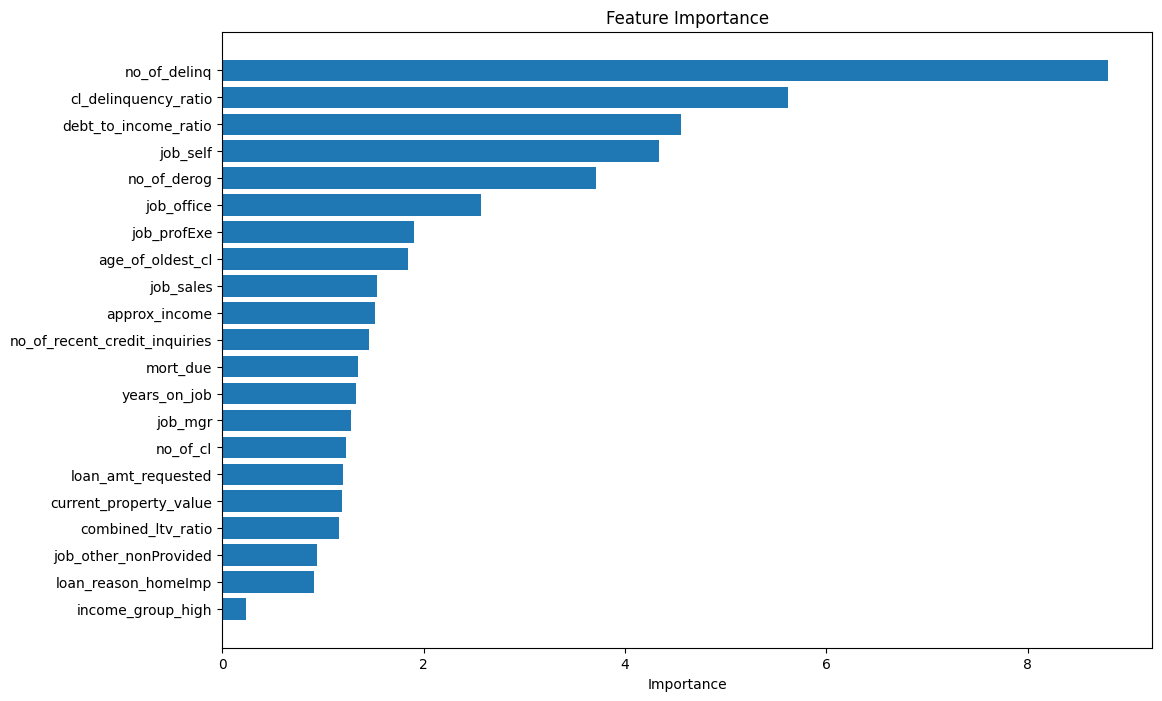

In [ ]:
# Prepare to plot
features, importance = zip(*sorted_importance)

plt.figure(figsize=(12, 8))
plt.barh(features, importance)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature on top
plt.show()

In [ ]:
sorted_importance

[('no_of_delinq', 8.793068885803223),
 ('cl_delinquency_ratio', 5.613473415374756),
 ('debt_to_income_ratio', 4.5566558837890625),
 ('job_self', 4.3396172523498535),
 ('no_of_derog', 3.713864803314209),
 ('job_office', 2.56752872467041),
 ('job_profExe', 1.9026751518249512),
 ('age_of_oldest_cl', 1.8445526361465454),
 ('job_sales', 1.5334669351577759),
 ('approx_income', 1.5150948762893677),
 ('no_of_recent_credit_inquiries', 1.4603773355484009),
 ('mort_due', 1.3455322980880737),
 ('years_on_job', 1.3282694816589355),
 ('job_mgr', 1.2782975435256958),
 ('no_of_cl', 1.2306416034698486),
 ('loan_amt_requested', 1.2008697986602783),
 ('current_property_value', 1.1918920278549194),
 ('combined_ltv_ratio', 1.1635710000991821),
 ('job_other_nonProvided', 0.9389479160308838),
 ('loan_reason_homeImp', 0.916013777256012),
 ('income_group_high', 0.23290158808231354)]

# Randomised search cv

In [ ]:
param_dist = {
    'clf__max_depth': [3, 4, 5, 6, 7, 8, 9, 10], #Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
    'clf__min_child_weight': [1, 2, 3, 4], # The larger min_child_weight is, the more conservative the algorithm will be.
    'clf__gamma': [0.0, 0.1, 0.2, 0.3, 0.4], #Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
    #'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],  #Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting.
    'clf__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9], #is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed
    'clf__lambda': [1, 1.5, 2], #L2 regularization term on weights. Increasing this value will make model more conservative.
    'clf__alpha': [0, 0.1, 0.2, 0.3], #L1 regularization term on weights. Increasing this value will make model more conservative.
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__n_estimators': [100, 200, 300, 400, 500],
   # 'scale_pos_weight': [1, 2, 3, 4]  # Depending on the class imbalance
}

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Set up RandomizedSearchCV
random_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=param_dist, n_iter=50
        , scoring= 'accuracy'
        # , refit = 'recall_bad'
        , n_jobs=-1, cv=cv, verbose=3, random_state=42)

In [ ]:
random_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:05:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('under',
                                              RandomUnderSampler(random_state=42)),
                                             ('clf',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eva...
                   param_distributions={'clf__alpha': [0, 0.1, 0.2, 0.3],
                                        'clf__colsample_bytree': [0.5, 0.6, 0.7,
                                                                  0.8, 0.9],
                                        'clf__gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'clf__lambda': [1, 1.5, 2],
                                        'clf__learning_rate': [0.01, 0.05, 0.1,
                                                               0.2],
                                        'clf__max_depth': [3, 4, 5, 6, 7, 8, 9,
                                                           10],
                                        'clf__min_child_weight': [1, 2, 3, 4],
                                        'clf__n_estimators': [100, 200, 300,
                                                              400, 500]},
                   random_state=42, scoring='accuracy', verbose=3)

In [ ]:
rand_model_xgb = random_xgb.best_estimator_
rand_params_xgb = random_xgb.best_params_
print("Best parameter: ",rand_params_xgb)

Best parameter:  {'clf__n_estimators': 400, 'clf__min_child_weight': 1, 'clf__max_depth': 9, 'clf__learning_rate': 0.2, 'clf__lambda': 2, 'clf__gamma': 0.2, 'clf__colsample_bytree': 0.8, 'clf__alpha': 0.2}


In [ ]:
#no refit


# Best parameter:  {'clf__n_estimators': 400, 'clf__min_child_weight': 1, 'clf__max_depth': 9,
                  # 'clf__learning_rate': 0.2, 'clf__lambda': 2, 'clf__gamma': 0.2, 'clf__colsample_bytree': 0.8, 'clf__alpha': 0.2}

rand_y_pred_rf = rand_model_xgb.predict(X_test)
rand_y_prob_rf = rand_model_xgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, rand_y_pred_rf, digits=3))
print("ROC‑AUC :", roc_auc_score(y_test, rand_y_prob_rf).round(3))
print("PR‑AUC  :", average_precision_score(y_test, rand_y_prob_rf).round(3))

cm_xgb = confusion_matrix(y_test, rand_y_pred_rf)
tn, fp, fn, tp = cm_xgb.ravel()
print(f"Recall (bad)         : {tp / (tp + fn):.3f}")
print(f"Specificity (good)   : {tn / (tn + fp):.3f}")
print(f"tn, fp, fn, tp   : {tn:.0f}, {fp:.0f}, {fn:.0f}, {tp:.0f}")

              precision    recall  f1-score   support

           0      0.963     0.878     0.919       932
           1      0.633     0.864     0.731       228

    accuracy                          0.875      1160
   macro avg      0.798     0.871     0.825      1160
weighted avg      0.899     0.875     0.882      1160

ROC‑AUC : 0.946
PR‑AUC  : 0.84
Recall (bad)         : 0.864
Specificity (good)   : 0.878
tn, fp, fn, tp   : 818, 114, 31, 197


In [ ]:
# print(f"CV recall (bad) of best model: {gs_rf.best_score_:.3f}")
print("Best accuracy train set: ",rand_model_xgb.score(X_train, y_train))
print("Best accuracy test set: ",rand_model_xgb.score(X_test, y_test))

Best accuracy train set:  0.9176013805004314
Best accuracy test set:  0.875


GridsearchCV

In [ ]:

#Best parameter:  {'clf__n_estimators': 400, 'clf__min_child_weight': 1, 'clf__max_depth': 9, 'clf__learning_rate': 0.2, 'clf__lambda': 2, 'clf__gamma': 0.2, 'clf__colsample_bytree': 0.8, 'clf__alpha': 0.2}

param_grid = {
    'clf__n_estimators': [400],               # Around 400
    'clf__max_depth': [9],                       # Around 9
    'clf__min_child_weight': [1],                    # Around 1
    'clf__learning_rate': [0.2],            # Around 0.2
    'clf__lambda': [2],                       # Around 2
    'clf__gamma': [0.2],                      # Around 0.2
    'clf__colsample_bytree': [0.8],           # Around 0.8
    'clf__subsample': [0.7],                  # New: reasonable range
    'clf__alpha': [0.2]                       # Around 0.2
}


In [ ]:
from sklearn.model_selection import GridSearchCV

# Set up GridSearchCV
grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid,
    scoring= 'accuracy',
    # refit='recall_bad',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search
grid_xgb.fit(X_train, y_train)



Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:05:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('under',
                                        RandomUnderSampler(random_state=42)),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metr...
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.2], 'clf__colsample_bytree': [0.8],
                         'clf__gamma': [0.2], 'clf__lambda': [2],
                         'clf__learning_rate': [0.2], 'clf__max_depth': [9],
                         'clf__min_child_weight': [1],
                         'clf__n_estimators': [400], 'clf__subsample': [0.7]},
             scoring='accuracy', verbose=2)

In [ ]:
# Get best model and make predictions
best_xgb = grid_xgb.best_estimator_
print(grid_xgb.best_params_)
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

y_pred_train = best_xgb.predict(X_train)

# Evaluation metrics

print("Accuracy test:", accuracy_score(y_test, y_pred))
print("Accuracy train:", accuracy_score(y_train, y_pred_train))

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC :", roc_auc_score(y_test, y_prob).round(3))
print("PR-AUC :", average_precision_score(y_test, y_prob).round(3))

cm_xgb = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm_xgb.ravel()
print(f"\nRecall (bad) : {tp / (tp + fn):.3f}")
print(f"Specificity (good) : {tn / (tn + fp):.3f}")
print(f"tn, fp, fn, tp : {tn:.0f}, {fp:.0f}, {fn:.0f}, {tp:.0f}")

# print(f"CV recall (bad) of best model: {gs_rf.best_score_:.3f}")
print("Best accuracy train set: ",best_xgb.score(X_train, y_train))
print("Best accuracy test set: ",best_xgb.score(X_test, y_test))

{'clf__alpha': 0.2, 'clf__colsample_bytree': 0.8, 'clf__gamma': 0.2, 'clf__lambda': 2, 'clf__learning_rate': 0.2, 'clf__max_depth': 9, 'clf__min_child_weight': 1, 'clf__n_estimators': 400, 'clf__subsample': 0.7}
Accuracy test: 0.8836206896551724
Accuracy train: 0.9163071613459879
              precision    recall  f1-score   support

           0      0.964     0.888     0.925       932
           1      0.654     0.864     0.745       228

    accuracy                          0.884      1160
   macro avg      0.809     0.876     0.835      1160
weighted avg      0.903     0.884     0.889      1160

ROC-AUC : 0.951
PR-AUC : 0.858

Recall (bad) : 0.864
Specificity (good) : 0.888
tn, fp, fn, tp : 828, 104, 31, 197
Best accuracy train set:  0.9163071613459879
Best accuracy test set:  0.8836206896551724


#adjust threshold

In [ ]:
best_y_pred = best_xgb.predict(X_test)
best_y_prob = best_xgb.predict_proba(X_test)[:, 1]

#  Threshold optimisation under recall + specificity constraints
thresholds = np.arange(0.01, 1.0, 0.01)
results_opt = []
for t in thresholds:
    y_pred_thresh = (best_y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    if recall >= 0.85 and specificity >= 0.70:
        results_opt.append({
            'threshold': t,
            'recall': recall,
            'specificity': specificity,
            'false_negatives': fn,
            'false_positives': fp
        })
opt_df = pd.DataFrame(results_opt)
if not opt_df.empty:
    # Choose threshold with fewest false negatives (or change to lowest total errors, highest precision, etc.)
    best_threshold = opt_df.sort_values(by='false_negatives').iloc[0]['threshold']
    print(f"\nBest threshold under constraints: {best_threshold:.2f}")
    print(opt_df.sort_values(by='false_negatives').head())
else:
    print("No threshold satisfies both recall ≥ 85% and specificity ≥ 70%.")
y_pred_thresh = (best_y_prob >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_thresh)
print("\nConfusion matrix (custom threshold):\n", cm)
print(classification_report(y_test, y_pred_thresh, digits=3))


Best threshold under constraints: 0.12
   threshold    recall  specificity  false_negatives  false_positives
0       0.12  0.960526     0.704936                9              275
1       0.13  0.960526     0.717811                9              263
2       0.14  0.960526     0.726395                9              255
3       0.15  0.956140     0.736052               10              246
4       0.16  0.947368     0.740343               12              242

Confusion matrix (custom threshold):
 [[657 275]
 [  9 219]]
              precision    recall  f1-score   support

           0      0.986     0.705     0.822       932
           1      0.443     0.961     0.607       228

    accuracy                          0.755      1160
   macro avg      0.715     0.833     0.714      1160
weighted avg      0.880     0.755     0.780      1160

